# Ejercicio Ciudades

El presente notebook presenta el analisis del desafio de ciudades. El tiempo es de 3 horas. A continuación se presentan el proceso de los resultados. Este notebook es reproducible en binder usando el link del [repositorio](https://github.com/waio1990/ciudades).



El objetivo es determinar si los estados de la costa este tienen más o menos ciudades que comparten nombre con el Reino Unido (UK), para ello se dispone de una base de datos pública.

Intentaré explicar paso a paso lo que voy haciendo incluyendo analisis exploratorios, etc.

In [1]:
import datetime as dt
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt


In [2]:
ti=dt.datetime.now() # tiempo inicial

En primer lugar abrimos la base de datos y realizamos un poco de exploración

In [3]:
url = "https://public.opendatasoft.com/explore/dataset/worldcitiespop/download/?format=csv&disjunctive.country=true&refine.country=us&refine.country=gb&timezone=America/Santiago&lang=en&use_labels_for_header=true&csv_separator=%3B"
df = pd.read_csv(url,sep=';')


In [4]:
df.head()

,Country,City,AccentCity,Region,Population,Latitude,Longitude,geopoint
0,us,lost creek,Lost Creek,KY,NaN,37.481667,-83.325278,"37.4816667,-83.3252778"
1,us,edgewood village,Edgewood Village,LA,NaN,32.400556,-93.842500,"32.4005556,-93.8425"
2,us,trout dale,Trout Dale,VA,NaN,36.701944,-81.440556,"36.7019444,-81.4405556"
3,us,trivoli,Trivoli,IL,NaN,40.690556,-89.891944,"40.6905556,-89.8919444"
4,us,barhamsville,Barhamsville,VA,NaN,37.454444,-76.840556,"37.4544444,-76.8405556"


Una ves cargada ambas bases de datos nos hace falta una pieza de información más: Qué estados se consideran parte de cada costa. Usando google encontramos la lista ([Wikipedia](https://en.wikipedia.org/wiki/East_Coast_of_the_United_States#:~:text=The%2014%20states%20that%20have,Carolina%2C%20Georgia%2C%20and%20Florida.))

Usando esto tenemos el listado de la costa este: **Maine, New Hampshire, Massachusetts, Rhode Island, Connecticut, New York, New Jersey, Delaware, Maryland, Virginia, North Carolina, South Carolina, Georgia, y Florida.** Es importante convertir esto a los codigos de 2 letras para poder filtrar luego.

[Wikipedia](https://en.wikipedia.org/wiki/West_Coast_of_the_United_States), nuevamente nos indica que generalmente se consideran **California, Oregon, Washington, y Alaska**

In [5]:
#creamos una lista con las costas, por sus codigos segun https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes
ec=['ME','NH','MA','RI','CT','NY','NJ','DE','MD','VA','NC','SC','GA','FL']
wc=['CA','OR','WA','AK']
# procedemos a filtrar la lista para incluir solo ciudades en cada área.
cec=df.loc[(df['Region'].isin(ec)) & (df['Country']=='us')]
cwc=df.loc[(df['Region'].isin(wc)) & (df['Country']=='us')]

# finalmente recuperamos los nombres de ciudades del reino unido para comparar
uk=df.loc[df['Country']=='gb','City']
uk.head() #veamos si la lista de UK parece razonable

197            yate
198          weston
200    stokenchurch
219        ramsgate
220       rhosneigr
Name: City, dtype: object

Antes de realizar la comparación y contar el numero de ciudades, me parece que aquelas ciudades de EEUU que tengan el prefijo "new" debiesen contar. Creo que el nombre "New" York esta claramente asociado a la ciudad de "York", por lo que antes de realizar las comparaciones, quitaré todos los prefijos "new " de los nombres de las ciudades. Es importante considerar el espacio antes para evitar cambiar el nombre de ciudades como "newark"



In [6]:
cwc["City2"]=None
cec["City2"]=None
cec["City2"]=cec.City.str.replace("new ","")
cwc["City2"]=cwc.City.str.replace("new ","")

#Este comando arroja una advertencia, en honor al tiempo no corregiré el codigo porque considero que perderia tiempo arreglando esta warning

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Procedemos a buscar cuantas ciudades de la costa este y oeste estan en ambos casos con la nueva lista de ciudades sin "new" en su nombre. 

In [7]:
matche=cec[cec["City2"].isin(uk.values)]
matchw=cwc[cwc["City2"].isin(uk.values)]
print(len(matche))
print(len(matchw))
matche.head() #observamos los matchs del este, donde la ciudad City2 existee en la lista de ciudades del reino unido

2819
581


,Country,City,AccentCity,Region,Population,Latitude,Longitude,geopoint,City2
72,us,hill,Hill,NH,NaN,43.524167,-71.701389,"43.5241667,-71.7013889",hill
140,us,coldstream,Coldstream,GA,NaN,33.917222,-84.403889,"33.9172222,-84.4038889",coldstream
196,us,falkland,Falkland,NC,NaN,35.699167,-77.513333,"35.6991667,-77.5133333",falkland
260,us,beaufort,Beaufort,NJ,NaN,40.817778,-74.330000,"40.8177778,-74.33",beaufort
333,us,bingham,Bingham,ME,NaN,45.058611,-69.882778,"45.0586111,-69.8827778",bingham


Obtenidos los numeros absolutos,la respuesta es evidente, la costa este tiene **2819** ciudades con nombres derivados el reino unido, mientras que la costa oeste tiene **581**. Ahora intentaremos representarlos de una forma más amigable. Para esto utilizaremos las capacidades del notebook.

## Dibujando un Mapa
En primer lugar agruparemos por estado el numero de ciudades con nombre similares para nuestra base, porque pretendo hacer un mapa que muestre por estado el numero de ciudades de origen inglés.

In [8]:
neast=matche.groupby('Region')['City'].count().reset_index()#agrupamos y generamos una nueva tabla
nwest=matchw.groupby('Region')['City'].count().reset_index()

A continuación, para dibujar, necesitamos una base de datos que contenga las coordenadas de las fronteras de los estados, y un paquete que las pueda usar. Este se llama geopandas (lo importamos al inicio con el nombre gpd). La base de datos no fue facil de encontrar, curiosamente. Una vez obtenida se subio al repositorio de este ejercicio para usarla posteriormente.

In [9]:
url = "gz_2010_us_040_00_5m.shp" 
geo = gpd.read_file(url)
geo.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,None,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,None,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,None,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,None,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,None,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


Vemos que contiene todos los estados y un campo "geometry" que tiene las coordenadas de sus fronteras, que utilizaremos para el mapa.

El archivo que encontre con los estados lamentablemente tiene los nombres de los estados enteros, por lo que busque un diccionario que me permitiera transformar rapidamente de uno al otro.

In [10]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [43]:
neast['llave']=neast.Region.map(states)#creamos una llave con el nombre completo del estado para unirlo a nuestra base de mapa
nwest['llave']=nwest.Region.map(states)#
nwest #revisamos que haya quedado bien

,Region,City,llave
0,AK,24,Alaska
1,CA,244,California
2,OR,112,Oregon
3,WA,201,Washington


Ahora procedemos a asignarle a cada estado el numero de ciudades, juntando las tablas anteriores. Los estados no considerados se llenaran con 0.

In [12]:

geo['nciudades']=geo.merge(pd.concat([neast,nwest])[['llave','City']],how='left',left_on='NAME',right_on='llave')['City']
geo['nciudades']=geo['nciudades'].fillna(0)

Finalmente podemos dibujar el mapa con colores:

In [ ]:
f, ax = plt.subplots(1, figsize=(12, 8))
ax = geo.plot(column='nciudades',ax=ax,legend=True,cmap='Greens',legend_kwds={'label': "Nunero de ciudades cuyos nombres provienen del Reino Unido",'orientation': "horizontal"})
ax.set_xlim(-190,-50)
ax.axis('off')
plt.show()



Lamentablemente Alaska, Hawai y Puerto Rico Distorsionan el mapa, por lo que para obener mayor claridad omitimos estos estados, que de todas formas no tienen muchas ciudades (alaska tiene 24)

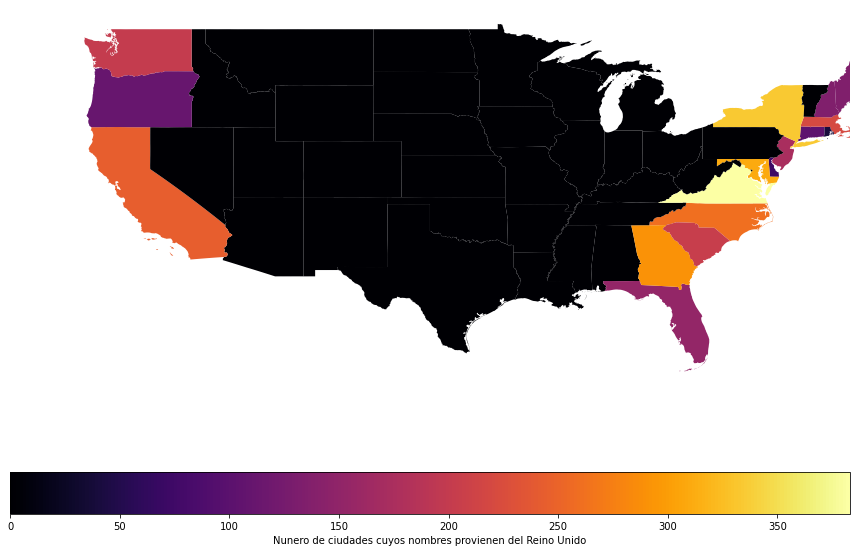

In [61]:
geo2=geo[~geo.NAME.isin(['Alaska','Hawaii','Puerto Rico'])] #sacamos estos territorios
f, ax = plt.subplots(1, figsize=(12, 8))
ax = geo2.plot(column='nciudades',ax=ax,legend=True,cmap='inferno',legend_kwds={'label': "Nunero de ciudades cuyos nombres provienen del Reino Unido",'orientation': "horizontal"})
ax.set_xlim(-130,-70)
ax.axis('off')
f.tight_layout()

In [66]:
pd.concat([neast,nwest])[['llave','City']].sort_values('City',ascending=False).head() #para observar el top 5 de estados

,llave,City
13,Virginia,383
10,New York,335
5,Maryland,310
3,Georgia,291
7,North Carolina,261


Podemos observar entonces que si bien en California puede haber bastantes ciudades con nombres derivados de gran bretaña, hay alrededor de 3 estados que concentran una gran cantidad de ciudades con esas características, por ejemplo Virginia, Nueva York y Georgia.

Esto es bastante consistente con lo enunciado. Me parece interesante observar el bajo numero (comparativamente) de los estados del Noreste considerando por ejemplo que esa zona se conoce como "New England". De hecho en Bostón comenzó la guerra de independencia de EEUU.

Florida parece razonable puesto que estuvo en poder de España hasta 1821 ([Wikipedia](https://en.wikipedia.org/wiki/History_of_Florida#American_Frontier))

In [13]:
tf=dt.datetime.now() 


datetime.timedelta(seconds=24, microseconds=609288)

In [ ]:
tf-ti